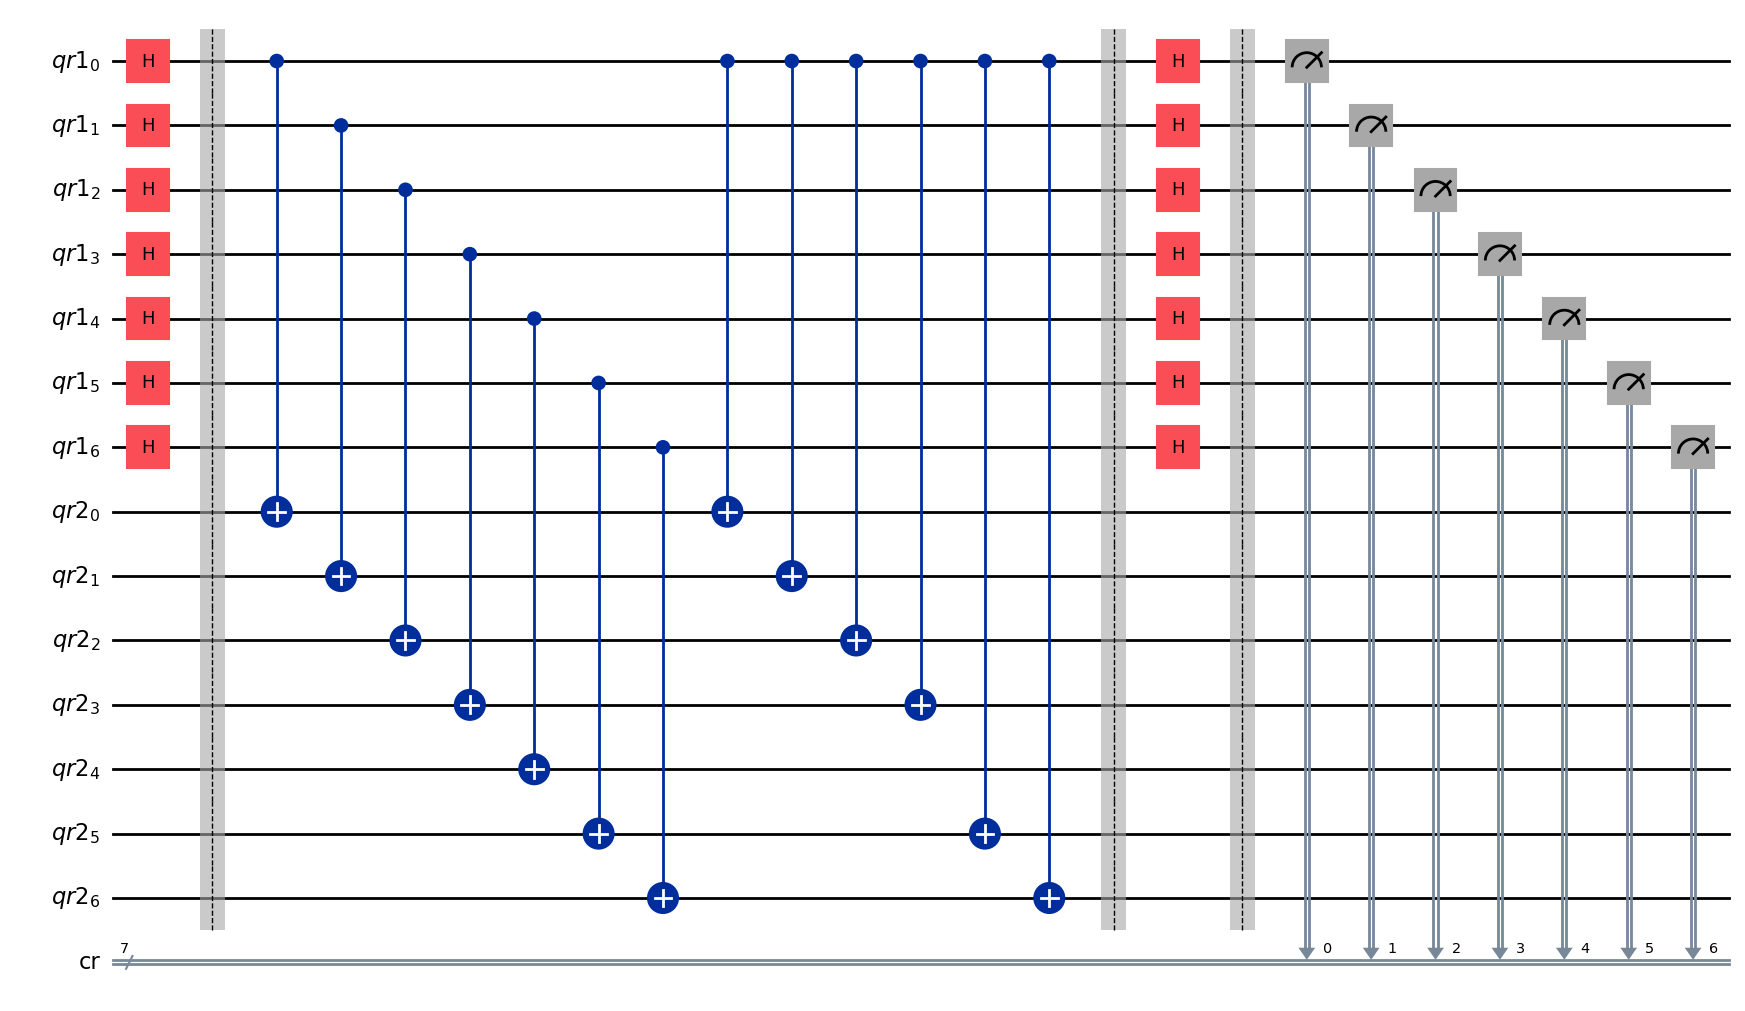

In [5]:
# full algorithm that solves system of equations for any s
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

s = '1101111'

n = len(s)
qr1 = QuantumRegister(n, 'qr1')
qr2 = QuantumRegister(n, 'qr2')
cr = ClassicalRegister(n, 'cr')
qc = QuantumCircuit(qr1, qr2, cr)

# first round of hadamards
qc.h(qr1)
qc.barrier()

# oracle
qc.cx(qr1, qr2)
firstOne = -1
for i in range(n):
    if s[n - i - 1] == '1' and firstOne == -1:
        firstOne = i
    if s[n - i - 1] == '1':
        qc.cx(qr1[firstOne], qr2[i])
qc.barrier()

# second round of hadamards
qc.h(qr1)
qc.barrier()

# measurement
qc.measure(qr1, cr)

qc.draw('mpl')

Counts: {'1101010': 16, '1011000': 12, '1110110': 14, '0111011': 24, '1010001': 22, '0111000': 13, '1010010': 17, '1100011': 10, '0011111': 17, '0001010': 15, '0100001': 15, '0011100': 26, '1100110': 17, '1111010': 15, '1000100': 21, '0101011': 20, '0000000': 16, '1111100': 16, '0110111': 16, '0100100': 17, '1001011': 18, '1111111': 25, '0101110': 12, '0000101': 12, '0110010': 22, '1110011': 15, '1011101': 17, '1101111': 19, '0010011': 15, '1100000': 17, '1000111': 22, '0111101': 12, '0001100': 12, '1110000': 14, '1001110': 14, '0010000': 19, '1011110': 20, '0010110': 12, '1101100': 14, '0010101': 13, '0100111': 13, '0110100': 15, '0000011': 21, '0101000': 17, '0000110': 22, '0110001': 15, '1100101': 15, '1000010': 8, '0101101': 16, '1111001': 15, '1000001': 15, '0011010': 14, '1001101': 20, '0100010': 9, '0111110': 17, '0001111': 18, '1110101': 17, '1010100': 19, '1010111': 13, '1101001': 13, '1001000': 16, '0001001': 16, '1011011': 10, '0011001': 7}


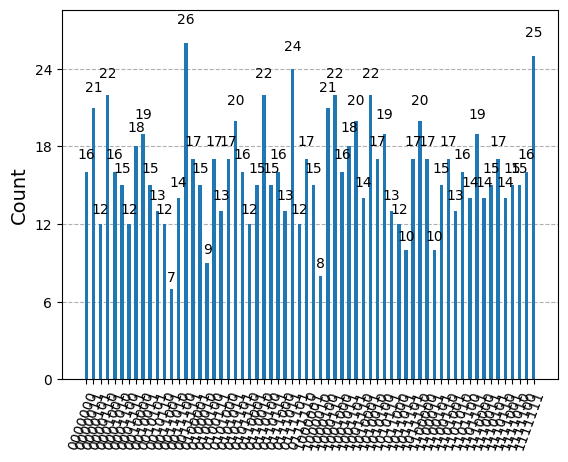

In [6]:
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

simulator = Aer.get_backend('aer_simulator')
job = simulator.run(qc, shots=1024)
result = job.result()
counts = result.get_counts(qc)
print("Counts:", counts)
plot_histogram(counts)

In [7]:
# finding output values
import numpy as np

# generating all possible binary strings of length n
def generate_binary(n):
    for i in range(2**n):
        yield format(i, '0{}b'.format(n))

# finding probable bits
def findImportantBits(counts):
    for binary_string in generate_binary(n):
        if counts.get(binary_string, 0) > 0:
            yield binary_string
    return None

vals = []
for binary_string in findImportantBits(counts):
    if (binary_string == '0' * n):
        continue
    print(binary_string)
    vals.append( [ int(c) for c in binary_string ] )
numVals = len(vals)

0000011
0000101
0000110
0001001
0001010
0001100
0001111
0010000
0010011
0010101
0010110
0011001
0011010
0011100
0011111
0100001
0100010
0100100
0100111
0101000
0101011
0101101
0101110
0110001
0110010
0110100
0110111
0111000
0111011
0111101
0111110
1000001
1000010
1000100
1000111
1001000
1001011
1001101
1001110
1010001
1010010
1010100
1010111
1011000
1011011
1011101
1011110
1100000
1100011
1100101
1100110
1101001
1101010
1101100
1101111
1110000
1110011
1110101
1110110
1111001
1111010
1111100
1111111


In [8]:
# solving system of equations
# found at https://github.com/amazon-braket/amazon-braket-examples/blob/f49bb6a68f1be280e4b00146022c35a5293d2f07/examples/advanced_circuits_algorithms/Simons_Algorithm/Simons_Algorithm.ipynb

from sympy import Matrix

print('The result in matrix form is :')
for a in vals:
    print (a)

M=Matrix(vals).T

# Construct the agumented matrix
M_I = Matrix(np.hstack([M,np.eye(M.shape[0],dtype=int)]))

# Perform row reduction, working modulo 2. We use the iszerofunc property of rref
# to perform the Gaussian elimination over the finite field.
M_I_rref = M_I.rref(iszerofunc=lambda x: x % 2==0)

# In row reduced echelon form, we can end up with a solution outside of the finite field {0,1}.
# Thus, we need to revert the matrix back to this field by treating fractions as a modular inverse.
# Since the denominator will always be odd (i.e. 1 mod 2), it can be ignored.

# Helper function to treat fractions as modular inverse:
def mod2(x):
    return x.as_numer_denom()[0] % 2

# Apply our helper function to the matrix
M_I_final = M_I_rref[0].applyfunc(mod2)

# Extract the kernel of M from the remaining columns of the last row, when s is nonzero.
if all(value == 0 for value in M_I_final[-1,:M.shape[1]]):
    result_s="".join(str(c) for c in M_I_final[-1,M.shape[1]:])

# Otherwise, the sub-matrix will be full rank, so just set s=0...0
else:
    result_s='0'*M.shape[0]

# Check whether result_s is equal to initial s:
print ('Secret string: ' + s)
print ('Result string: ' + result_s)
if (result_s == s):
    print ('We found the correct answer.')
else:
    print ('Error. The answer is wrong!')

The result in matrix form is :
[0, 0, 0, 0, 0, 1, 1]
[0, 0, 0, 0, 1, 0, 1]
[0, 0, 0, 0, 1, 1, 0]
[0, 0, 0, 1, 0, 0, 1]
[0, 0, 0, 1, 0, 1, 0]
[0, 0, 0, 1, 1, 0, 0]
[0, 0, 0, 1, 1, 1, 1]
[0, 0, 1, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 1, 1]
[0, 0, 1, 0, 1, 0, 1]
[0, 0, 1, 0, 1, 1, 0]
[0, 0, 1, 1, 0, 0, 1]
[0, 0, 1, 1, 0, 1, 0]
[0, 0, 1, 1, 1, 0, 0]
[0, 0, 1, 1, 1, 1, 1]
[0, 1, 0, 0, 0, 0, 1]
[0, 1, 0, 0, 0, 1, 0]
[0, 1, 0, 0, 1, 0, 0]
[0, 1, 0, 0, 1, 1, 1]
[0, 1, 0, 1, 0, 0, 0]
[0, 1, 0, 1, 0, 1, 1]
[0, 1, 0, 1, 1, 0, 1]
[0, 1, 0, 1, 1, 1, 0]
[0, 1, 1, 0, 0, 0, 1]
[0, 1, 1, 0, 0, 1, 0]
[0, 1, 1, 0, 1, 0, 0]
[0, 1, 1, 0, 1, 1, 1]
[0, 1, 1, 1, 0, 0, 0]
[0, 1, 1, 1, 0, 1, 1]
[0, 1, 1, 1, 1, 0, 1]
[0, 1, 1, 1, 1, 1, 0]
[1, 0, 0, 0, 0, 0, 1]
[1, 0, 0, 0, 0, 1, 0]
[1, 0, 0, 0, 1, 0, 0]
[1, 0, 0, 0, 1, 1, 1]
[1, 0, 0, 1, 0, 0, 0]
[1, 0, 0, 1, 0, 1, 1]
[1, 0, 0, 1, 1, 0, 1]
[1, 0, 0, 1, 1, 1, 0]
[1, 0, 1, 0, 0, 0, 1]
[1, 0, 1, 0, 0, 1, 0]
[1, 0, 1, 0, 1, 0, 0]
[1, 0, 1, 0, 1, 1, 1]
[1, 0, 1, 1, 0, 0, 0]
[